Potential V(0,0):1.0
Potential V(1,0):0.0
Potential V(2,0):-0.45
Potential V(5,0):-1.05


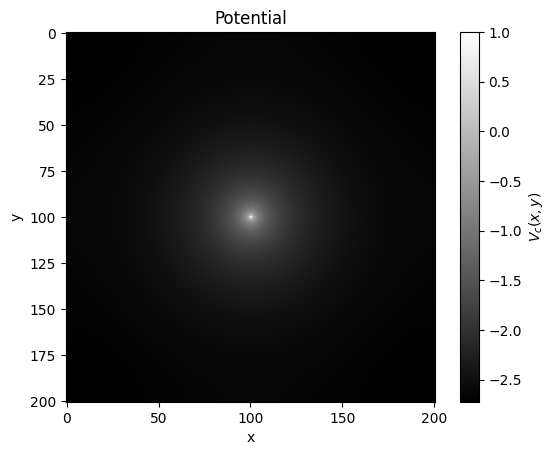

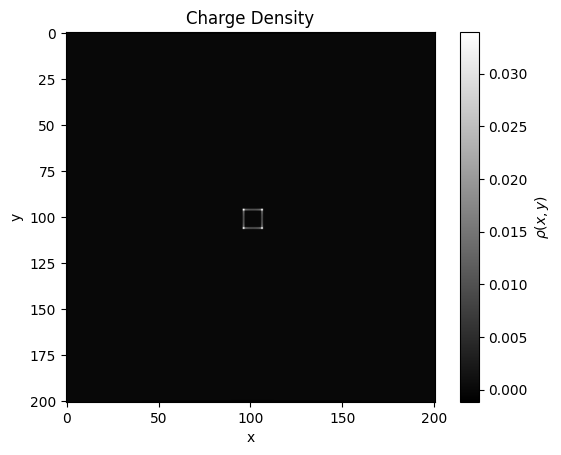

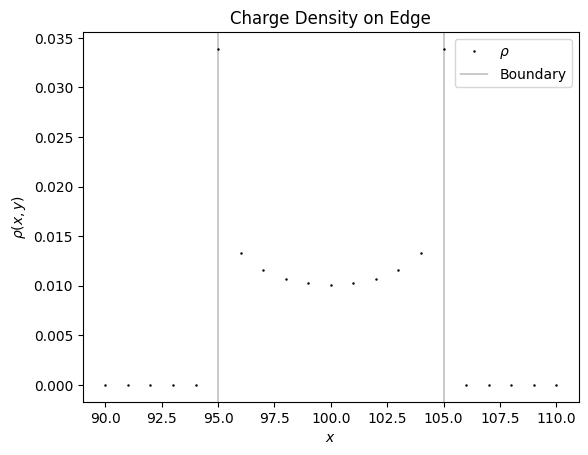

Inside box mean(V):0.81176366407859, stdev(V):0.020256367539625803


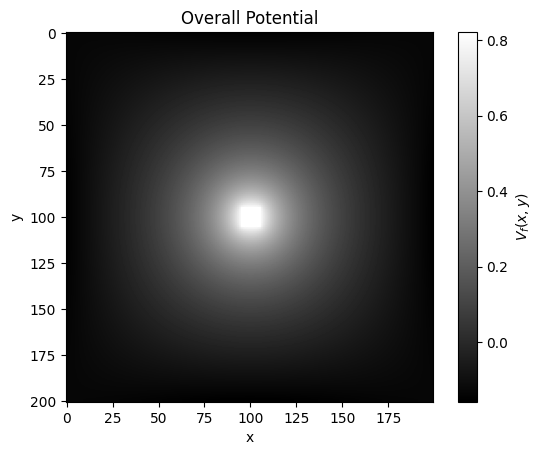

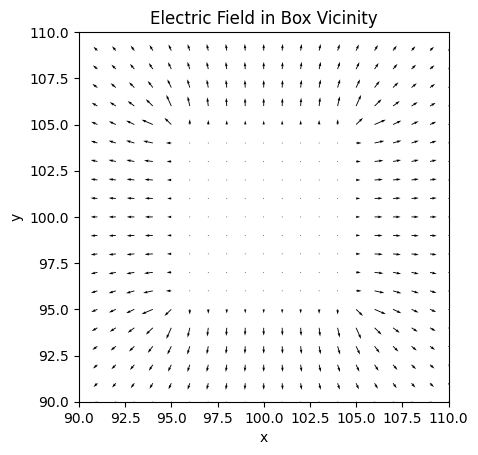

In [65]:
##############Assignment 8#################
###########################################

import numpy as np
from matplotlib import pyplot as plt


#Parts of the code in this assignment were adapted from the lecture notes.

#################Problem 2#################
###########################################

#function to average four neighboring values
def average_neighbors(mat):
    out=0*mat
    out=out+np.roll(mat,1,0)
    out=out+np.roll(mat,-1,0)
    out=out+np.roll(mat,1,1)
    out=out+np.roll(mat,-1,1)
    return out/4
    
class Grid:#part b
    def __init__(self,bc,mask):
        self.bc=bc
        self.mask=mask
    def make_rhs(self):
        rhs=average_neighbors(self.bc)
        rhs[self.mask]=0 #we need to zero out the RHS on the boundary
        return rhs
    def __matmul__(self,x):
        x[self.mask]=0
        ave=average_neighbors(x)
        ave[self.mask]=0
        return x-ave

def conjgrad(A,b,x=None,niter=1000, res=1e-16):
    if x is None:
        x=0*b
    r=b-A@x
    p=r.copy()
    rtr=np.sum(r**2)
    while rtr>res:
        for i in range(niter):
            Ap=A@p
            pAp=np.sum(p*Ap)
            alpha=rtr/pAp
            x=x+alpha*p
            r=r-alpha*Ap
            rtr_new=np.sum(r**2)
            beta=rtr_new/rtr
            p=r+beta*p
            rtr=rtr_new
    return x


############part (a)############
n=201
m=n//2

#Set up greens

nx=np.linspace(-m,m,n)
ny=np.linspace(-m,m,n)

#calculate the point potential V=rho+ave(neighboring four potentials)
def Vcalc(vg, vr, gm, niter):
    for i in range(int(niter)):
        vg=average_neighbors(vg)+vr        
    return vg
    
g0=np.zeros([n,n])#V
gr=np.zeros([n,n])
gr[m,m]=1#set Vmid=1


g=Vcalc(g0,gr,m,n*5*10)
g=g+1-g[m,m]#offset for V[0,0=1]


print('Potential V(0,0):{}'.format(np.round(g[m,m],2)))
print('Potential V(1,0):{}'.format(np.round(g[m+1,m],2)))
print('Potential V(2,0):{}'.format(np.round(g[m+2,m],2)))
print('Potential V(5,0):{}'.format(np.round(g[m+5,m],2)))

Vc=g.copy()

plt.figure()
plt.imshow(Vc)
plt.title('Potential')
plt.colorbar(label='$V_{c}(x,y)$')
plt.xlabel('x')
plt.ylabel('y')

plt.gray()
plt.show()


############part (b)############



w=5#edge length 

mask=np.zeros([n,n],dtype='bool')
bc=np.zeros([n,n])



mask[:,0]=True
mask[0,:]=True
mask[-1,:]=True
mask[:,-1]=True

#for 201x202 grid positioning
bc[m-w+1:m+w+2,m-w+1:m+w+2]=1.0
mask[m-w+1:m+w+2,m-w+1:m+w+2]=True


A=Grid(bc,mask)
b=A.make_rhs()

x=conjgrad(A,b,niter=5*n)

V=x.copy()
V[A.mask]=A.bc[A.mask]
rho=V-average_neighbors(V)


plt.figure()
plt.imshow(rho)
plt.colorbar(label='$\\rho(x,y)$')
plt.title('Charge Density')
plt.xlabel('x')
plt.ylabel('y')
# plt.gray()

mx=np.linspace(90,110,21)
plt.figure()
plt.plot(mx, rho[m-w+1,m-w+1-5:m+w+2+5],'ko',ms=0.75,label='$\\rho$')
plt.title('Charge Density on Edge')
plt.xlabel('$x$')
plt.ylabel('$\\rho(x,y)$')
plt.axvline(m-w, lw=.3, color='k', ls="-", label='Boundary')
plt.axvline(m+w, lw=.3, color='k', ls="-")
plt.legend()
plt.show()

############part (c)############

#generate the potential in
Vf = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho) * np.fft.rfft2(Vc)))

# plt.gray()
plt.imshow(Vf)
plt.title('Overall Potential')
plt.colorbar(label='$V_{f}(x,y)$')
plt.xlabel('x')
plt.ylabel('y')


print('Inside box mean(V):{}, stdev(V):{}'.format(np.mean(Vf[m-w+1:m+w+2,m-w+1:m+w+2]),np.std(Vf[m-w+1:m+w+2,m-w+1:m+w+2])))



Ey, Ex = np.gradient(Vf)
Ey, Ex = -Ey, -Ex
xx=np.arange(n-1)
yy=np.arange(n)
qx,qy=np.meshgrid(xx,yy)

fig, ax = plt.subplots()
ax.quiver(qx, qy, Ex, Ey)
ax.set_aspect('equal')

plt.xlim(90,110)
plt.ylim(90,110)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Electric Field in Box Vicinity')
plt.show()
